In [ ]:
# This project is inspired by "Understanding deep learning requires rethinking generalization" (arXiv:1611.03530v2)
# The codes are modification from "Laboratory 2: Computer Vision" of MIT 6.S191: Introduction to Deep Learning
# © MIT 6.S191: Introduction to Deep Learning
# http://introtodeeplearning.com

In [1]:
import tensorflow as tf 
import matplotlib.pyplot as plt
import numpy as np

# 1. Download and Visualize the Data 

In [2]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = (np.expand_dims(train_images, axis=-1)/255.).astype(np.float32)
train_labels = (train_labels).astype(np.int64)
test_images = (np.expand_dims(test_images, axis=-1)/255.).astype(np.float32)
test_labels = (test_labels).astype(np.int64)

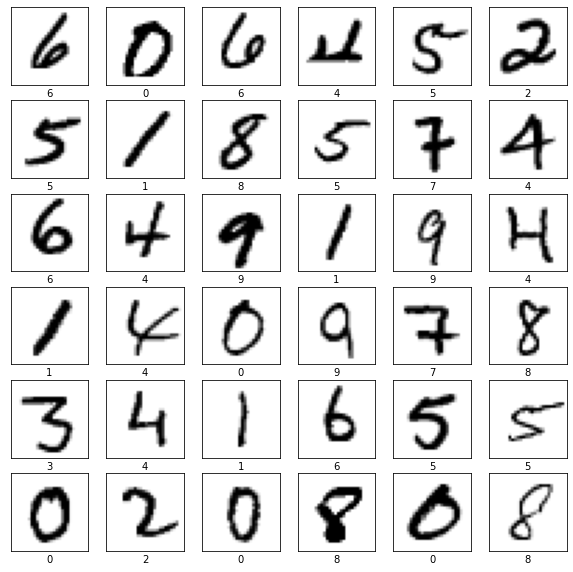

In [3]:
plt.figure(figsize=(10,10))
random_inds = np.random.choice(60000,36)
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image_ind = random_inds[i]
    plt.imshow(np.squeeze(train_images[image_ind]), cmap=plt.cm.binary)
    plt.xlabel(train_labels[image_ind])

# 2. Use Convolution Neural Network to Train (Not Randomized)  


In [4]:
def build_cnn_model():
    cnn_model = tf.keras.Sequential([
        # the first convolutional layer
        tf.keras.layers.Conv2D(filters=24, kernel_size=(3,3), activation=tf.nn.relu),
        # the first max pooling layer
        tf.keras.layers.MaxPool2D(pool_size=(2,2)),
        # the second convolutional layer
        tf.keras.layers.Conv2D(filters=36, kernel_size=(3,3), activation=tf.nn.relu),
        # the second max pooling layer
        tf.keras.layers.MaxPool2D(pool_size=(2,2)),
        # fully connected networks
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation=tf.nn.relu),
        # output should be 10 classification probabilities
        tf.keras.layers.Dense(10, activation=tf.nn.softmax)
    ])
    return cnn_model

In [5]:
cnn_model = build_cnn_model()
# Compilation
cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [6]:
# Fitting the Model
BATCH_SIZE = 64
EPOCHS = 5
cnn_model.fit(train_images, train_labels, batch_size=BATCH_SIZE, epochs=EPOCHS)

Epoch 1/5
938/938 [==============================] - 5s 3ms/step - loss: 0.4259 - accuracy: 0.8722
Epoch 2/5
938/938 [==============================] - 2s 3ms/step - loss: 0.0573 - accuracy: 0.9828
Epoch 3/5
938/938 [==============================] - 2s 3ms/step - loss: 0.0401 - accuracy: 0.9877
Epoch 4/5
938/938 [==============================] - 2s 3ms/step - loss: 0.0323 - accuracy: 0.9903
Epoch 5/5
938/938 [==============================] - 2s 3ms/step - loss: 0.0242 - accuracy: 0.9923


In [7]:
train_loss, train_acc = cnn_model.evaluate(train_images, train_labels)
test_loss, test_acc = cnn_model.evaluate(test_images, test_labels)
print('Train accuracy:', train_acc, 'Test accuracy:', test_acc)

313/313 [==============================] - 1s 2ms/step - loss: 0.0315 - accuracy: 0.9898
Train accuracy: 0.9953833222389221 Test accuracy: 0.989799976348877


# 3. Use CNN and Randomize the Labels
"Partially corrupted labels: independently with probability p, the label of each image is
corrupted as a uniform random class" (from Zhang's paper)

In [8]:
def randomize_label(labels, probability):
    labels_random = []
    for elem in labels:
        random = np.random.choice([True, False], p=[probability, 1-probability])
        if random:
            labels_random.append(np.random.choice(10, 1)[0])
        else:
            labels_random.append(elem)
    return np.array(labels_random)

In [9]:
Randomization = np.arange(0, 1.1, 0.1)

In [10]:
BATCH_SIZE = 64
EPOCHS = 5
test_acc_list = []
train_acc_list = []
for probability in Randomization:
    # Randomize part of the labels according to the probability
    train_labels_random = randomize_label(train_labels, probability)
    test_labels_random = randomize_label(test_labels, probability)
    
    # Create, compile, and fit a new model for every randomness
    cnn_model = build_cnn_model()
    cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    cnn_model.fit(train_images, train_labels_random, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=0)
    
    # Evaluate the accuracy for train and test set
    train_loss, train_acc = cnn_model.evaluate(train_images, train_labels_random, verbose=0)
    test_loss, test_acc = cnn_model.evaluate(test_images, test_labels_random, verbose=0)
    test_acc_list.append(test_acc)
    train_acc_list.append(train_acc)

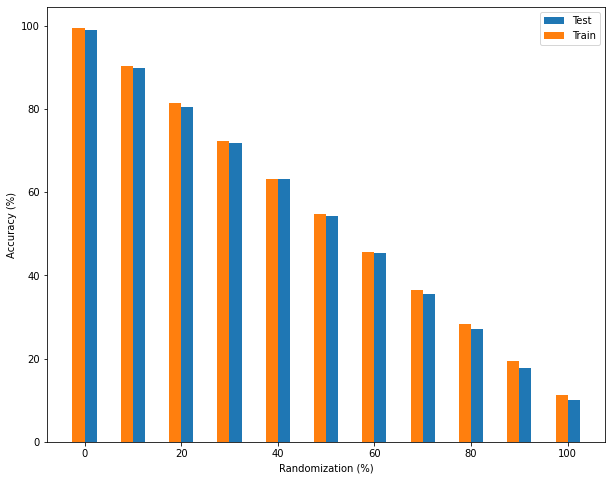

In [11]:
# Convolution Neural Network
plt.figure(figsize=(10,8))
plt.bar(Randomization*100+1.25, np.array(test_acc_list)*100, width=2.5, label="Test")
plt.bar(Randomization*100-1.25, np.array(train_acc_list)*100, width=2.5, label="Train")
plt.xlabel('Randomization (%)')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

# 4. Use Fully Connected Neural Network to Train the Randomized Labels  

In [12]:
def build_fc_model():
  fc_model = tf.keras.Sequential([
      # Flatten layer
      tf.keras.layers.Flatten(),
      # Hidden layer
      tf.keras.layers.Dense(128, activation=tf.nn.relu),
      # Output should be 10 classification probabilities
      tf.keras.layers.Dense(10, activation=tf.nn.softmax) 
  ])
  return fc_model

In [13]:
BATCH_SIZE = 64
EPOCHS = 5
test_acc_list = []
train_acc_list = []
for probability in Randomization:
    # Randomize part of the labels according to the probability
    train_labels_random = randomize_label(train_labels, probability)
    test_labels_random = randomize_label(test_labels, probability)
    
    # Create, compile, and fit a new model for every randomness
    fc_model = build_fc_model()
    fc_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    fc_model.fit(train_images, train_labels_random, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=0)
    
    # Evaluate the accuracy for train and test set
    train_loss, train_acc = fc_model.evaluate(train_images, train_labels_random, verbose=0)
    test_loss, test_acc = fc_model.evaluate(test_images, test_labels_random, verbose=0)
    test_acc_list.append(test_acc)
    train_acc_list.append(train_acc)

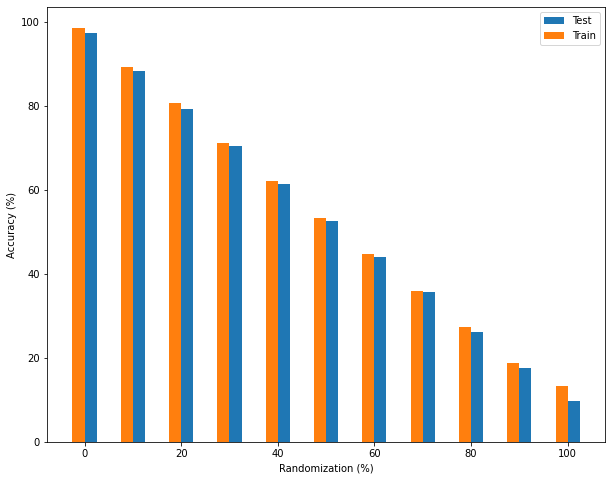

In [14]:
# Fully Connected Neural Network
plt.figure(figsize=(10,8))
plt.bar(Randomization*100+1.25, np.array(test_acc_list)*100, width=2.5, label="Test")
plt.bar(Randomization*100-1.25, np.array(train_acc_list)*100, width=2.5, label="Train")
plt.xlabel('Randomization (%)')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

# 5. Use Fully Connected Neural Network to Train the Randomized Labels with Large Epochs

In [15]:
BATCH_SIZE = 64
EPOCHS = 1000
test_acc_list = []
train_acc_list = []
for probability in Randomization:
    # Randomize part of the labels according to the probability
    train_labels_random = randomize_label(train_labels, probability)
    test_labels_random = randomize_label(test_labels, probability)
    
    # Create, compile, and fit a new model for every randomness
    fc_model = build_fc_model()
    fc_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    fc_model.fit(train_images, train_labels_random, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=0)
    
    # Evaluate the accuracy for train and test set
    train_loss, train_acc = fc_model.evaluate(train_images, train_labels_random, verbose=0)
    test_loss, test_acc = fc_model.evaluate(test_images, test_labels_random, verbose=0)
    test_acc_list.append(test_acc)
    train_acc_list.append(train_acc)

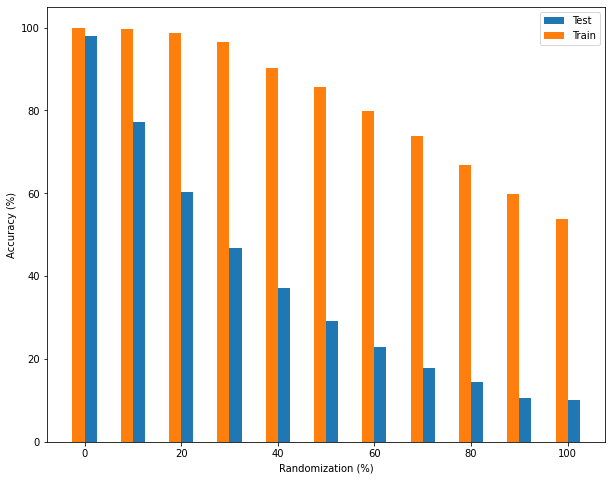

In [16]:
# Fully Connected Neural Network with Large Epochs
# Epochs could be set even higher to get higher accuracy for the train set
plt.figure(figsize=(10,8))
plt.bar(Randomization*100+1.25, np.array(test_acc_list)*100, width=2.5, label="Test")
plt.bar(Randomization*100-1.25, np.array(train_acc_list)*100, width=2.5, label="Train")
plt.xlabel('Randomization (%)')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()